In [26]:
################################
# Solves - u'' + u = f         #
# With zero Dirichlet boundary #
################################
import radiant as rad
import numpy as np


# Problem Parameters
a = -0.5
b = 0.5


def exact(*x):
    return np.prod(np.sin(np.asarray(x) * 2 * np.pi / (b - a)), axis=0)


def f(*x):
    return (len(x) * (2 * np.pi / (b - a)) ** 2 + 1) * exact(*x)


def g(*x):
    return np.zeros_like(x[0])

In [27]:
# Parameters
d = 1
k = 2
inner = 6
outer = 1
start_delta = 1.5
start_N = 51

# Computed Parameters
ranges = ((a, b),) * d
phi = rad.Wendland(d, k)
centre_thinning = 2 ** np.arange(inner)
delta_thinning = 2. ** np.arange(inner)
xcs = [rad.gridinc(ranges, inc, flat=True) for inc in (b - a) / (centre_thinning * start_N)]
deltas = start_delta / delta_thinning
filters = [
    lambda arr, lst: arr[np.all([np.logical_and(c != a, c != b) for c in lst], axis=0)],
    lambda arr, lst: arr[np.any([np.logical_or(c == a, c == b) for c in lst], axis=0)],
]
operators = [
    lambda rbf, *args: - rbf.laplacian(*args) + rbf(*args),
    lambda rbf, *args: rbf(*args),
]
integrator = rad.integrate.MeanIntegrator(ranges, 1000)
# integrator = rad.integrate.QuadIntegrator(ranges, epsabs=1e-3, epsrel=1e-3)

# Solve for approximate solution
solver = rad.solve.MultilevelSolver(rad.solve.CollocationSolver, phi, deltas, xcs, operators, filters, outer=outer)
approx = solver.solve(f, g)
error = rad.error(exact, approx, integrator)

print("L2 Relative Error:", error)
print("Condition Number:", solver.cond())

L2 Relative Error: 2.217307481399775
Condition Number: [758.0705503891298, 43556.34200408845, 101540.50363654963, 263574.52235050604, 1264048.0293461524, 56051812.5531955]


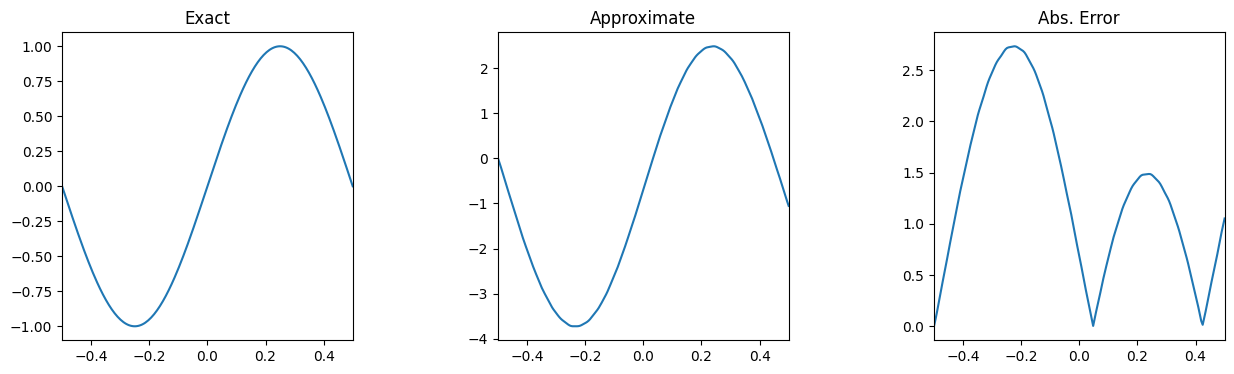

In [28]:
rad.plot.spread(
    ranges,
    exact,
    approx,
    lambda *x: np.abs(exact(*x) - approx(*x )),
    n=200,
    wspace=0.5,
    hspace=0.5,
    titles=["Exact", "Approximate", "Abs. Error"],
    figsize=(15, 4),
)

Once 
 
 Loop 
 
 Reflect

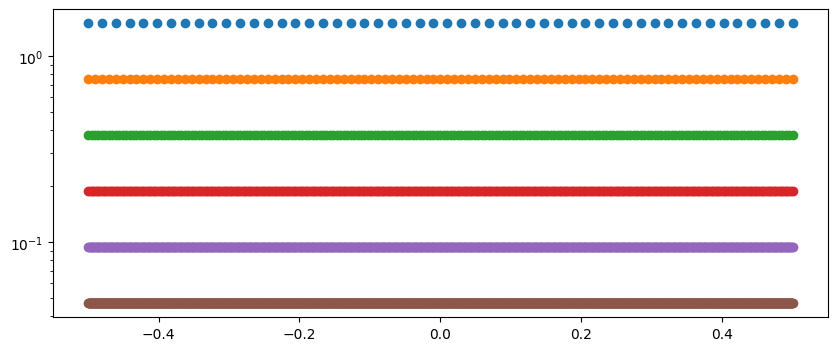

In [29]:
if d == 1:
    from IPython.display import HTML, display_html
    
    
    anim = rad.animate.ml_animate(ranges, exact, approx, n=200, figsize=(10, 4))
    display_html(HTML(anim.to_jshtml()))
    
    rad.plot.thinning(deltas, xcs, d, figsize=(10, 4))